# Tutorial: Scorecard monitoring

This tutorial is a continuation of the two previous scorecard tutorials, where we focus on scorecard monitoring. Scorecard monitoring is important to determine if the distribution of new data has shifted with respect to the original data used to develop the scorecard. Besides, monitoring is also useful to detect errors in raw data and track scorecard performance.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import ScorecardMonitoring

#### Binary target

We use the Home equity line of credit (HELOC) dataset from FICO Explainable Machine Learning Challenge https://community.fico.com/s/explainable-machine-learning-challenge.

In [3]:
df = pd.read_csv("data/FICO_challenge/heloc_dataset_v1.csv", sep=",")

variable_names = list(df.columns[1:])

target = "RiskPerformance"
y = df[target].values
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

df[target] = y

For this example, we split data to compare the robustness of the developed scorecard in the test dataset.

In [4]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[target],
                                     random_state=42)

As in the previous example, we specify a list of special codes and a selection criteria to be applied in the binning process.

In [5]:
special_codes = [-9, -8, -7]

In [6]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 1},
    "quality_score": {"min": 0.01}
}

In [7]:
binning_process = BinningProcess(variable_names, special_codes=special_codes,
                                 selection_criteria=selection_criteria)

In [8]:
estimator = LogisticRegression(solver="lbfgs")

Now, we instantiate a  ``Scorecard`` class with the target name, a binning process object, and an estimator, and fit with training data.

In [9]:
scorecard = Scorecard(target=target, binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 0, "max": 100})

In [10]:
scorecard.fit(df_train)

Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                         binning_transform_params=None,
                                         categorical_variables=None,
                                         max_bin_size=None, max_n_bins=None,
                                         max_n_prebins=20, max_pvalue=None,
                                         max_pvalue_policy='consecutive',
                                         min_bin_size=None, min_n_bins=None,
                                         min_prebin_size=0.05, n_jobs=None,
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02},
                                                             'quality_score':...
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                       fit_intercept=True, intercept_scaling=1,
               

In [11]:
scorecard.information(print_level=2)

optbinning (Version 0.12.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                   RiskPerformance   * U
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                   7321
    Number of variables                   23
    Target type                       binary

    Number of numerical                   23
    Number of categorical                  0
    Number of selected                    21

  Timing
    Total time                          2.12 sec
    Binning process                     1.85 sec   ( 87.64%)
    Esti

Once the scorecard is fitted, we use the ``ScorecardMonitoring`` class to ensure that the resulting scorecard is discriminating using train and test data. Furthermore, this class analyzes whether the distribution of train and test data differ significantly. In practice, ``df_train`` would be the (expected) data used for scorecard development, whereas ``df_test`` would be the (actual) evolved data.

In [12]:
monitoring = ScorecardMonitoring(target=target, scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=10, verbose=True)

In [13]:
monitoring.fit(df_test, df_train)

2020-09-18 18:23:01,073 | INFO : Monitoring started.
2020-09-18 18:23:01,077 | INFO : Options: check parameters.
2020-09-18 18:23:01,080 | INFO : System stability analysis started.
2020-09-18 18:23:01,375 | INFO : System stability analysis terminated. Time: 0.2938s
2020-09-18 18:23:01,376 | INFO : Variable analysis started.
2020-09-18 18:23:01,509 | INFO : Variable analysis terminated. Time: 0.1331s
2020-09-18 18:23:01,511 | INFO : Monitoring terminated. Time: 0.4373s


ScorecardMonitoring(psi_method='cart', psi_min_bin_size=0.05, psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                                                       binning_transform_params=None,
                                                                       categorical_variables=None,
                                                                       max_bin_size=None,
                                                                       max_n_bins=None,
                                                                       max_n_prebins=20,
                                                                       max_pvalue=None,
                                                                       max_pvalue_policy='consecutive',
                                                                       min_bin_size=None,
                                                                       min_n_

Similar to other objects in OptBinning, we can print overview information about the options settings, data statistics and CPU times.

In [14]:
monitoring.information(print_level=2)

optbinning (Version 0.12.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                   RiskPerformance   * U
    scorecard                            yes   * U
    psi_method                          cart   * d
    psi_n_bins                            10   * U
    psi_min_bin_size                    0.05   * d
    show_digits                            2   * d
    verbose                             True   * U
  End options

  Statistics
    Number of records Actual            3138
    Number of records Expected          7321
    Number of scorecard variables         21
    Target type                       binary

  Timing
    Total time                          0.44 sec
    System stability                    0.29 sec   ( 67.18%)
    Variables stability                 0.13 sec   ( 30.44%)



The method ``psi_table`` returns the Population Stability Index (PSI) table. The PSI is a divergence measure equivalent to the Information Value (IV), also known as Jeffry's divergence. This measure assesses whether the actual score distribution has shifted from the expected score distribution. This analysis requires the segmentation of the score with respect to the target, using the options ``psi_method``, ``psi_n_bins`` and ``psi_min_bin_size``.

In [15]:
monitoring.psi_table()

,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,"[-inf, 42.15)",245,599,0.078075,0.081819,0.000175
1,"[42.15, 47.17)",310,735,0.098789,0.100396,0.000026
2,"[47.17, 52.28)",390,939,0.124283,0.128261,0.000125
3,"[52.28, 54.40)",187,418,0.059592,0.057096,0.000107
4,"[54.40, 58.72)",505,1269,0.160931,0.173337,0.000921
5,"[58.72, 61.84)",284,542,0.090504,0.074034,0.003308
6,"[61.84, 66.23)",329,832,0.104844,0.113646,0.000710
7,"[66.23, 68.50)",177,401,0.056405,0.054774,0.000048
8,"[68.50, 73.14)",346,747,0.110261,0.102035,0.000638
9,"[73.14, inf)",365,839,0.116316,0.114602,0.000025


We can plot the PSI table using method ``psi_plot``, where the population distribution and event rate for each bin (Bin ID) are shown. 

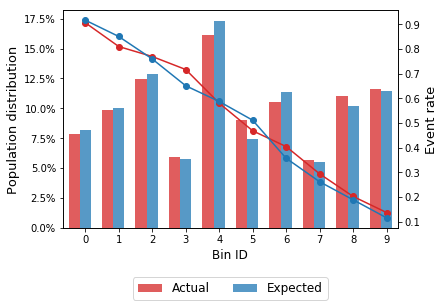

In [16]:
monitoring.psi_plot()

This analysis computes statistical tests to determine if the event rate on train and test data are significantly different using the Chi-square test. The null hypothesis is that actual = expected.

In [17]:
monitoring.tests_table()

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"[-inf, 42.15)",245,599,0.906122,0.916528,0.238260,0.625466
1,"[42.15, 47.17)",310,735,0.809677,0.850340,2.659300,0.102946
2,"[47.17, 52.28)",390,939,0.769231,0.759318,0.149387,0.699122
3,"[52.28, 54.40)",187,418,0.716578,0.650718,2.538841,0.111076
4,"[54.40, 58.72)",505,1269,0.580198,0.587076,0.070406,0.790747
5,"[58.72, 61.84)",284,542,0.468310,0.511070,1.363016,0.243015
6,"[61.84, 66.23)",329,832,0.404255,0.356971,2.260461,0.132715
7,"[66.23, 68.50)",177,401,0.293785,0.261845,0.633186,0.426189
8,"[68.50, 73.14)",346,747,0.202312,0.188755,0.278998,0.597359
9,"[73.14, inf)",365,839,0.136986,0.115614,1.083924,0.297821


Finally, the ``system_stability_report`` method summarizes the findings encountered throughout the analysis. Moreover, it returns a comparison with the performance of the provided scorecard on both train and test data, to identify if the developed scorecard suffers a deterioration in predictiveness on the actual/evolved data. 

In [18]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0061 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0        0.0
    [0.05, 0.10)      0        0.0
    [0.10, 0.50)      6        0.6
    [0.50, 1.00)      4        0.4

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records    3138          -      7321            -
        Event records    1638   0.521989      3821     0.521923
    Non-event records    1500   0.478011      3500     0.478077

  Performance metrics

                 Metric    Actual  Expected  Diff A - E
     True positive rate  0.723270  0.736465   -0.013195
     True negative rate  0.

The ``ScorecardMonitoring`` also implements functionalities to perform the characteristic stability report. The ``psi_variable_table``method returns the PSI using the optimal bins incorporated in the scorecard at a characteristic level.

In [19]:
monitoring.psi_variable_table(style="detailed")

,Variable,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,ExternalRiskEstimate,"[-inf, 59.50)",322,759,0.102613,0.103674,0.000011
1,ExternalRiskEstimate,"[59.50, 63.50)",326,771,0.103888,0.105313,0.000019
2,ExternalRiskEstimate,"[63.50, 65.50)",193,488,0.061504,0.066658,0.000415
3,ExternalRiskEstimate,"[65.50, 67.50)",205,447,0.065328,0.061057,0.000289
4,ExternalRiskEstimate,"[67.50, 70.50)",302,736,0.096240,0.100533,0.000187
...,...,...,...,...,...,...,...
6,PercentTradesWBalance,"[73.50, 75.50)",178,382,0.056724,0.052179,0.000380
7,PercentTradesWBalance,"[75.50, 84.50)",328,851,0.104525,0.116241,0.001245
8,PercentTradesWBalance,"[84.50, 89.50)",199,434,0.063416,0.059282,0.000279
9,PercentTradesWBalance,"[89.50, inf)",481,1134,0.153282,0.154897,0.000017


In [20]:
monitoring.psi_variable_table(style="summary")

,Variable,PSI
0,AverageMInFile,0.004383
1,ExternalRiskEstimate,0.003521
2,MSinceMostRecentDelq,0.001321
3,MSinceMostRecentInqexcl7days,0.001347
4,MSinceMostRecentTradeOpen,0.000591
5,MSinceOldestTradeOpen,0.002840
6,MaxDelq2PublicRecLast12M,0.000798
7,MaxDelqEver,0.000751
8,NetFractionInstallBurden,0.003300
9,NetFractionRevolvingBurden,0.007549


#### Continuous target

Similar monitoring is available for a scorecard with a continuous target.

In [21]:
data = fetch_california_housing()

target = "target"
variable_names = data.feature_names
df = pd.DataFrame(data.data, columns=variable_names)
df[target] = data.target

In [22]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [23]:
binning_process = BinningProcess(variable_names)

In [24]:
estimator = HuberRegressor(max_iter=200)

In [25]:
scorecard = Scorecard(binning_process=binning_process, target=target,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 0, "max": 100},
                      reverse_scorecard=True)

In [26]:
scorecard.fit(df_train)

Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                         binning_transform_params=None,
                                         categorical_variables=None,
                                         max_bin_size=None, max_n_bins=None,
                                         max_n_prebins=20, max_pvalue=None,
                                         max_pvalue_policy='consecutive',
                                         min_bin_size=None, min_n_bins=None,
                                         min_prebin_size=0.05, n_jobs=None,
                                         selection_criteria=None,
                                         special_codes=None, split_digits=None,
                                         v...
                                                         'AveRooms',
                                                         'AveBedrms',
                                                         'Population',
           

In [27]:
monitoring = ScorecardMonitoring(target=target, scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=10)

monitoring.fit(df_test, df_train)

ScorecardMonitoring(psi_method='cart', psi_min_bin_size=0.05, psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                                                       binning_transform_params=None,
                                                                       categorical_variables=None,
                                                                       max_bin_size=None,
                                                                       max_n_bins=None,
                                                                       max_n_prebins=20,
                                                                       max_pvalue=None,
                                                                       max_pvalue_policy='consecutive',
                                                                       min_bin_size=None,
                                                                       min_n_

In [28]:
monitoring.information(print_level=2)

optbinning (Version 0.12.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                            target   * U
    scorecard                            yes   * U
    psi_method                          cart   * d
    psi_n_bins                            10   * U
    psi_min_bin_size                    0.05   * d
    show_digits                            2   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records Actual            6192
    Number of records Expected         14448
    Number of scorecard variables          8
    Target type                   continuous

  Timing
    Total time                          0.21 sec
    System stability                    0.16 sec   ( 77.02%)
    Variables stability                 0.05 sec   ( 22.13%)



In [29]:
monitoring.psi_table()

,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,"[-inf, 52.85)",406,936,0.065568,0.064784,0.000009
1,"[52.85, 54.79)",591,1425,0.095446,0.098630,0.000104
2,"[54.79, 56.66)",760,1651,0.122739,0.114272,0.000605
3,"[56.66, 58.27)",720,1718,0.116279,0.118909,0.000059
4,"[58.27, 60.26)",933,2206,0.150678,0.152685,0.000027
5,"[60.26, 62.42)",930,2196,0.150194,0.151993,0.000021
6,"[62.42, 64.54)",765,1683,0.123547,0.116487,0.000415
7,"[64.54, 66.06)",298,723,0.048127,0.050042,0.000075
8,"[66.06, 68.68)",310,753,0.050065,0.052118,0.000083
9,"[68.68, inf)",479,1157,0.077358,0.080080,0.000094


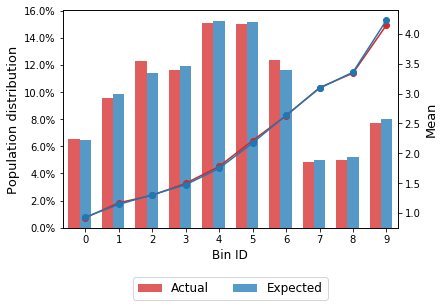

In [30]:
monitoring.psi_plot()

This analysis computes statistical tests to determine if the mean on train and test data are significantly different using the Student's t-test. The null hypothesis is that actual = expected.

In [31]:
monitoring.tests_table()

,Bin,Count A,Count E,Mean A,Mean E,Std A,Std E,statistic,p-value
0,"[-inf, 52.85)",406,936,0.917599,0.928611,0.409209,0.464387,-0.434347,0.664145
1,"[52.85, 54.79)",591,1425,1.169032,1.142058,0.581299,0.474639,0.998453,0.318319
2,"[54.79, 56.66)",760,1651,1.294764,1.303615,0.537874,0.570967,-0.368109,0.712842
3,"[56.66, 58.27)",720,1718,1.495086,1.471256,0.612125,0.610807,0.877447,0.380400
4,"[58.27, 60.26)",933,2206,1.778741,1.747470,0.707982,0.683559,1.142569,0.253378
5,"[60.26, 62.42)",930,2196,2.212506,2.172169,0.779740,0.765665,1.329353,0.183908
6,"[62.42, 64.54)",765,1683,2.627056,2.636392,0.824681,0.816150,-0.260460,0.794545
7,"[64.54, 66.06)",298,723,3.099715,3.089139,0.907654,0.907909,0.169259,0.865654
8,"[66.06, 68.68)",310,753,3.342927,3.359123,0.896253,0.860849,-0.270873,0.786589
9,"[68.68, inf)",479,1157,4.149947,4.230732,0.899871,0.850762,-1.678601,0.093598


In [32]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0015 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0        0.0
    [0.05, 0.10)      1        0.1
    [0.10, 0.50)      4        0.4
    [0.50, 1.00)      5        0.5

  Target analysis

    Metric    Actual  Expected
      Mean  2.066968  2.069240
       Std  1.145754  1.157492
       p25  1.202750  1.193000
    Median  1.810000  1.793000
       p75  2.650500  2.646000

  Performance metrics

                   Metric    Actual  Expected  Diff A - E
      Mean absolute error  0.527814  0.522824    0.004991
       Mean squared error  0.517115  0.509157    0.007958
    Median absolute error  0.410382

In [33]:
monitoring.psi_variable_table(style="detailed")

,Variable,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,MedInc,"[-inf, 1.82)",534,1253,0.086240,0.086725,0.000003
1,MedInc,"[1.82, 2.24)",533,1252,0.086079,0.086656,0.000004
2,MedInc,"[2.24, 2.57)",511,1112,0.082526,0.076966,0.000388
3,MedInc,"[2.57, 2.83)",409,997,0.066053,0.069006,0.000129
4,MedInc,"[2.83, 3.07)",383,876,0.061854,0.060631,0.000024
...,...,...,...,...,...,...,...
1,Longitude,"[-122.28, -122.12)",326,746,0.052649,0.051633,0.000020
2,Longitude,"[-122.12, -121.45)",815,1923,0.131621,0.133098,0.000016
3,Longitude,"[-121.45, -118.33)",1772,4206,0.286176,0.291113,0.000084
4,Longitude,"[-118.33, -118.17)",637,1507,0.102875,0.104305,0.000020


In [34]:
monitoring.psi_variable_table(style="summary")

,Variable,PSI
0,AveBedrms,0.002229
1,AveOccup,0.003518
2,AveRooms,0.001965
3,HouseAge,0.001815
4,Latitude,0.003628
5,Longitude,0.000740
6,MedInc,0.001032
7,Population,0.001363
